In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import argparse
import os
from collections import defaultdict

import torch

from habitat.utils.visualizations.utils import (
    images_to_video,
    observations_to_image,
)
from habitat_baselines.common.baseline_registry import baseline_registry

# taken from Joanne's code but not working
# from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.utils.env_utils import construct_envs

from habitat_baselines.common.environments import get_env_class

# taken from Joanne's code but not working
# from habitat_baselines.common.utils import batch_obs, generate_video
from habitat_baselines.utils.common import batch_obs, generate_video

from habitat_baselines.config.default import get_config

# from habitat_baselines.rl.ddppo.policy.resnet_policy import (
#     PointNavResNetPolicy,
# )

from my_habitat_baselines.resnet_policy import PointNavResNetPolicy

In [3]:
jupyter_dir = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter"

jupyter_dir

'/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter'

In [4]:
#
# evalsim.sh
#

# SENSORS="RGB_SENSOR"
# NOISE_MULTIPLIER="0.5"
# NOISE_MODEL_CONTROLLER="Proportional"
# AGENT_RADIUS="0.20"
# SENSOR_POSITION="[0,0.6096,0]"
# BACKBONE="resnet50"
# HIDDEN_SIZE=512
# NUM_RECURRENT_LAYERS=2
# NORMALIZE_VISUAL_INPUTS=1

# VIDEO_OPTION="['disk']"

# EPISODE_DATASET_PATH="obstacle_1/{split}/{split}.json.gz"
# EPISODE_DATASET_SPLIT="minival"

# python -u evaluation/evaluate_simulation.py \
#     --model-path ${MODEL_PATH} \
#     --sensors ${SENSORS} \
#     --hidden-size ${HIDDEN_SIZE} \
#     --normalize-visual-inputs ${NORMALIZE_VISUAL_INPUTS} \
#     --backbone ${BACKBONE} \
#     --num-recurrent-layers ${NUM_RECURRENT_LAYERS} \
#     "TEST_EPISODE_COUNT" "5" \
#     "TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER" ${NOISE_MODEL_CONTROLLER} \
#     "TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER" ${NOISE_MULTIPLIER} \
#     "TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV" "45" \
#     "TASK_CONFIG.SIMULATOR.RGB_SENSOR.VFOV" "45" \
#     "TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV" "45" \
#     "TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.VFOV" "45" \
#     "TASK_CONFIG.SIMULATOR.TURN_ANGLE" "30" \
#     "TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS" ${AGENT_RADIUS} \
#     "TASK_CONFIG.DATASET.DATA_PATH" ${EPISODE_DATASET_PATH} \
#     "TASK_CONFIG.DATASET.SPLIT" ${EPISODE_DATASET_SPLIT} \
#     "TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY" "False" \
#     "TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION" ${SENSOR_POSITION} \
#     "TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION" ${SENSOR_POSITION} \
#     "VIDEO_OPTION" ${VIDEO_OPTION} \
#     "TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION" "5000" \

# need to specify model_path, not included in evalsim.sh
model_path = "/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models"

arg_string = ""

arg_string += "--model-path %s" % model_path
arg_string += \
"""
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45
"""

# TASK_CONFIG.SIMULATOR.RGB_SENSOR.VFOV 45 # causes errors when calling habitat.Env(config.TASK_CONFIG)

arg_string += \
"""
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45
"""

# TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.VFOV 45 # causes errors when calling habitat.Env(config.TASK_CONFIG)

arg_string += \
"""
TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000
"""

print(arg_string)

parser = argparse.ArgumentParser()
parser.add_argument("--model-path", type=str, required=True)
parser.add_argument("--sensors", type=str, required=True)
parser.add_argument("--hidden-size", type=int, required=True)
parser.add_argument(
    "--normalize-visual-inputs", type=int, required=True, choices=[0, 1]
)
parser.add_argument(
    "--backbone",
    type=str,
    required=True,
    choices=["resnet50", "se_resneXt50"],
)
parser.add_argument("--num-recurrent-layers", type=int, required=True)
parser.add_argument(
    "opts",
    default=None,
    nargs=argparse.REMAINDER,
    help="Modify config options from command line",
)
args = parser.parse_args(arg_string.split())

print(args)

--model-path /Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models
--sensors RGB_SENSOR
--hidden-size 512
--normalize-visual-inputs 1
--backbone resnet50
--num-recurrent-layers 2
TEST_EPISODE_COUNT 5
TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER Proportional
TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER 0.5
TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV 45

TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV 45

TASK_CONFIG.SIMULATOR.TURN_ANGLE 30
TASK_CONFIG.SIMULATOR.AGENT_0.RADIUS 0.20
TASK_CONFIG.DATASET.DATA_PATH obstacle_1/{split}/{split}.json.gz
TASK_CONFIG.DATASET.SPLIT minival
TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY False
TASK_CONFIG.SIMULATOR.RGB_SENSOR.POSITION [0,0.6096,0]
TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.POSITION [0,0.6096,0]
VIDEO_OPTION ['disk']
TASK_CONFIG.TASK.TOP_DOWN_MAP.MAP_RESOLUTION 5000

Namespace(backbone='resnet50', hidden_size=512, model_path='/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models', normalize_visual_inputs=1, num_

In [10]:
# # Check torch version
# vtorch = "1.2.0"
# assert torch.__version__ == vtorch, "Please use torch {}".format(vtorch)

# config = get_config(
#     "habitat_baselines/config/pointnav/ppo_pointnav.yaml", args.opts
# )

habitat_dir = "/Users/mroberts/code/github/habitat-lab"
os.chdir(habitat_dir)

config = get_config(
    "habitat_baselines/config/pointnav/ppo_pointnav.yaml"
)

from habitat.config import Config as CN

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL = CN()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = None
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = None
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HFOV = None
# config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.VFOV = None # causes errors when calling habitat.Env(config.TASK_CONFIG)
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HFOV = None
# config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.VFOV = None # causes errors when calling habitat.Env(config.TASK_CONFIG)
config.TASK_CONFIG.ENVIRONMENT.GENERATE_ON_FLY = None
config.freeze()

config.merge_from_list(args.opts)

config.defrost()
# config.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = "pyrobotnoisy"
config.freeze()

config.defrost()
config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = "ILQR"    # our pre-trained model lists "proportional" in the filename, so don't change to ILQR 
# config.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 1.0 # our pre-trained model lists "0.5" in the filename, so don't change to 1.0
config.freeze()

config.defrost()
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ["*"]
config.TASK_CONFIG.DATASET.DATA_PATH = "data/datasets/pointnav/gibson/v1/train/train.json.gz" # don't have obstacle_1 scenes, so use Gibson instead
config.freeze()

config.defrost()
config.NUM_ENVIRONMENTS = 1
config.freeze()

In [11]:
config.defrost()
if args.sensors == "":
    config.SENSORS = []
else:
    config.SENSORS = args.sensors.split(",")
# TODO(akadian): collisions are not working
# config.TASK_CONFIG.TASK.MEASUREMENTS.append("COLLISIONS")
config.freeze()

In [16]:
print(config)

BASE_TASK_CONFIG_PATH: configs/tasks/pointnav_gibson.yaml
CHECKPOINT_FOLDER: data/new_checkpoints
CHECKPOINT_INTERVAL: -1
CMD_TRAILING_OPTS: []
ENV_NAME: NavRLEnv
EVAL:
  SPLIT: val
  USE_CKPT_CONFIG: True
EVAL_CKPT_PATH_DIR: data/new_checkpoints
FORCE_BLIND_POLICY: False
FORCE_TORCH_SINGLE_THREADED: True
LOG_FILE: train.log
LOG_INTERVAL: 25
NUM_CHECKPOINTS: 100
NUM_ENVIRONMENTS: 1
NUM_PROCESSES: -1
NUM_UPDATES: 10000
ORBSLAM2:
  ANGLE_TH: 0.2617993877991494
  BETA: 100
  CAMERA_HEIGHT: 1.25
  DEPTH_DENORM: 10.0
  DIST_REACHED_TH: 0.15
  DIST_TO_STOP: 0.05
  D_OBSTACLE_MAX: 4.0
  D_OBSTACLE_MIN: 0.1
  H_OBSTACLE_MAX: 1.25
  H_OBSTACLE_MIN: 0.375
  MAP_CELL_SIZE: 0.1
  MAP_SIZE: 40
  MIN_PTS_IN_OBSTACLE: 320.0
  NEXT_WAYPOINT_TH: 0.5
  NUM_ACTIONS: 3
  PLANNER_MAX_STEPS: 500
  PREPROCESS_MAP: True
  SLAM_SETTINGS_PATH: habitat_baselines/slambased/data/mp3d3_small1k.yaml
  SLAM_VOCAB_PATH: habitat_baselines/slambased/data/ORBvoc.txt
PROFILING:
  CAPTURE_START_STEP: -1
  NUM_STEPS_TO_CAPT

In [13]:
print(config.ENV_NAME)
print(get_env_class(config.ENV_NAME))

NavRLEnv
<class 'habitat_baselines.common.environments.NavRLEnv'>


In [14]:
from habitat_baselines.common.environments import NavRLEnv

In [17]:
# envs = construct_envs(config, get_env_class(config.ENV_NAME))

# construct a single env instead of multiple envs for simplicity
env = NavRLEnv(config)

2021-11-08 18:09:31,037 Initializing dataset PointNav-v1
2021-11-08 18:11:42,308 initializing sim Sim-v0
I1108 18:11:42.309854 199089600 ManagedFileBasedContainer.h:210] <Dataset>::convertFilenameToPassedExt : Filename : default changed to proposed scene_dataset_config.json filename : default.scene_dataset_config.json
I1108 18:11:46.383781 27272 simulator.py:221] Loaded navmesh data/scene_datasets/gibson/Roeville.navmesh
I1108 18:11:42.309885 199089600 AttributesManagerBase.h:365] <Dataset>::createFromJsonOrDefaultInternal : Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
I1108 18:11:42.309975 199089600 AssetAttributesManager.cpp:120] Asset attributes (capsule3DSolid : capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
I1108 18:11:42.310019 199089600 AssetAttributesManager.cpp:120] Asset attributes (capsule3DWireframe : capsule3DWireframe_hemiRings

Renderer: AMD Radeon Pro 5500M OpenGL Engine by ATI Technologies Inc.
OpenGL version: 4.1 ATI-3.10.22
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_ES2_compatibility
    GL_ARB_separate_shader_objects
    GL_ARB_texture_storage
    GL_EXT_texture_filter_anisotropic
    GL_EXT_debug_label
    GL_EXT_debug_marker
Using driver workarounds:
    no-layout-qualifiers-on-old-glsl
    apple-buffer-texture-unbind-on-buffer-modify


ta/scene_datasets/gibson/Roeville.glb' specified in Scene Attributes exists in dataset library.
I1108 18:11:46.383008 199089600 SceneDatasetAttributes.cpp:85] ::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes no_lights specified in Scene Attributes exists in dataset library.
I1108 18:11:46.383020 199089600 Simulator.cpp:171] ::reconfigure : createSceneInstance success == true for active scene name : data/scene_datasets/gibson/Roeville.glb with renderer.
I1108 18:11:46.389816 199089600 PathFinder.cpp:382] Building navmesh with 541x112 cells
I1108 18:11:46.470546 199089600 PathFinder.cpp:652] Created navmesh with 341 vertices 158 polygons
I1108 18:11:46.470584 199089600 Simulator.cpp:790] reconstruct navmesh successful


In [24]:
# action_space = envs.action_spaces[0]
# observation_space = envs.observation_spaces[0]
# print(action_space)
# print(observation_space)

action_space = env.action_space
observation_space = env.observation_space
print(action_space)
print(observation_space)

ActionSpace(MOVE_FORWARD:EmptySpace(), STOP:EmptySpace(), TURN_LEFT:EmptySpace(), TURN_RIGHT:EmptySpace())
Dict(pointgoal_with_gps_compass:Box([-3.4028235e+38 -3.4028235e+38], [3.4028235e+38 3.4028235e+38], (2,), float32), rgb:Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [2

dict_keys(['rgb', 'pointgoal_with_gps_compass'])


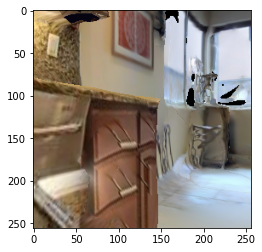

In [21]:
observation = env.reset()
print(observation.keys())

imshow(observation["rgb"]);

{'rgb': array([[[180, 166, 134],
        [180, 166, 134],
        [180, 165, 134],
        ...,
        [215, 218, 229],
        [216, 219, 230],
        [218, 220, 230]],

       [[180, 166, 134],
        [180, 166, 134],
        [180, 165, 134],
        ...,
        [215, 217, 231],
        [216, 218, 233],
        [219, 221, 235]],

       [[179, 166, 134],
        [180, 166, 134],
        [180, 165, 134],
        ...,
        [215, 217, 232],
        [216, 218, 233],
        [219, 221, 236]],

       ...,

       [[102,  69,  60],
        [104,  71,  62],
        [ 99,  66,  57],
        ...,
        [192, 219, 248],
        [194, 220, 249],
        [195, 221, 250]],

       [[100,  66,  58],
        [100,  67,  58],
        [ 96,  63,  54],
        ...,
        [192, 219, 248],
        [193, 221, 250],
        [194, 221, 251]],

       [[ 97,  64,  55],
        [ 97,  64,  55],
        [ 93,  60,  51],
        ...,
        [191, 218, 247],
        [191, 218, 248],
        [191, 21

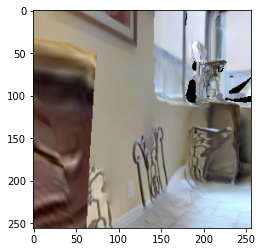

In [28]:
observation, reward, done, info = env.step(action="MOVE_FORWARD")
print(observation)
print(reward)
print(done)
print(info)

imshow(observation["rgb"]);

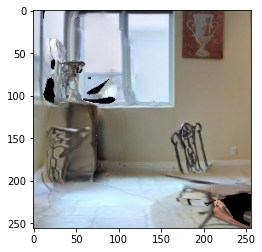

In [29]:
observation, reward, done, info = env.step(action="TURN_RIGHT")
imshow(observation["rgb"]);

In [30]:
device = (
    torch.device("cuda:{}".format(config.TORCH_GPU_ID))
    if torch.cuda.is_available()
    else torch.device("cpu")
)

device

device(type='cpu')

In [31]:
model_path = \
"/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/" + \
"job_19633792"                        + "." \
"sensor_RGB_SENSOR"                   + "." \
"train_data_gibson"                   + "." \
"noise_multiplier_0.5"                + "." \
"noise_model_controller_Proportional" + "." \
"agent_radius_0.20"                   + "." \
"success_reward_10.0"                 + "." \
"slack_reward_-0.01"                  + "." \
"collision_reward_0.0"                + "." \
"spl_max_collisions_500"              + "_" \
"ckpt.000000049"                      + \
".pth"

print(model_path)

/Users/mroberts/code/github/interiorsim/code/experiments/srcc/jupyter/models/job_19633792.sensor_RGB_SENSOR.train_data_gibson.noise_multiplier_0.5.noise_model_controller_Proportional.agent_radius_0.20.success_reward_10.0.slack_reward_-0.01.collision_reward_0.0.spl_max_collisions_500_ckpt.000000049.pth


In [32]:
def load_model(
    path,
    observation_space,
    action_space,
    hidden_size,
    normalize_visual_inputs,
    backbone,
    num_recurrent_layers,
    device,
):

    model = PointNavResNetPolicy(
        observation_space=observation_space,
        action_space=action_space,
        hidden_size=hidden_size,
        normalize_visual_inputs=normalize_visual_inputs,
        backbone=backbone,
        num_recurrent_layers=num_recurrent_layers,
        goal_sensor_uuid="pointgoal_with_gps_compass",
    )

    model.to(device)

    new_model_params = sum(
        [torch.numel(p) for _, p in model.named_parameters()]
    )

    saved_model = torch.load(path, map_location=device)
    saved_model_params = sum(
        [torch.numel(v) for k, v in saved_model["state_dict"].items()]
    )

    print(
        "new_model_params: {}, saved_model_params: {}".format(
            new_model_params, saved_model_params
        )
    )

    saved_model_state_dict = {}
    for k, v in saved_model["state_dict"].items():
        new_k = k.replace("actor_critic.", "")
        saved_model_state_dict[new_k] = v

    model.load_state_dict(saved_model_state_dict)

    return model



model = load_model(
    path=model_path,
    observation_space=observation_space,
    action_space=action_space,
    hidden_size=args.hidden_size,
    normalize_visual_inputs=bool(args.normalize_visual_inputs),
    backbone=args.backbone,
    num_recurrent_layers=args.num_recurrent_layers,
    device=device,
)

new_model_params: 12458053, saved_model_params: 12458060


In [33]:
model.eval()

PointNavResNetPolicy(
  (net): PointNavResNetNet(
    (prev_action_embedding): Embedding(5, 32)
    (tgt_embeding): Linear(in_features=3, out_features=32, bias=True)
    (visual_encoder): ResNetEncoder(
      (running_mean_and_var): RunningMeanAndVar()
      (backbone): ResNet(
        (conv1): Sequential(
          (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): GroupNorm(16, 32, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
        )
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (convs): Sequential(
              (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): GroupNorm(16, 32, eps=1e-05, affine=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (4): GroupNorm(16, 32, e

In [34]:
new_model_params = 0
for k,v in model.state_dict().items():
    # print(k, torch.numel(v))
    new_model_params += torch.numel(v)
    
print(new_model_params)

12458060


In [35]:
saved_model = torch.load(model_path, map_location=device)

saved_model_params = 0
for k,v in saved_model["state_dict"].items():
    # print(k, torch.numel(v))
    saved_model_params += torch.numel(v)
    
print(saved_model_params)

12458060


In [36]:
# print(config)

In [37]:
# metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
# metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
# measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
# assert measure_type is not None, "invalid measurement type {}".format(
#     metric_cfg.TYPE
# )
# metric_uuid = measure_type(None, None)._get_uuid()

metric_name = config.TASK_CONFIG.TASK.MEASUREMENTS[0]
metric_cfg = getattr(config.TASK_CONFIG.TASK, metric_name)
measure_type = baseline_registry.get_measure(metric_cfg.TYPE)
assert measure_type is not None, "invalid measurement type {}".format(
    metric_cfg.TYPE
)
metric_uuid = measure_type(None, None)._get_uuid()

print(metric_name)
print(metric_cfg)
print(measure_type)
print(metric_uuid)

DISTANCE_TO_GOAL
DISTANCE_TO: POINT
TYPE: DistanceToGoal
<class 'habitat.tasks.nav.nav.DistanceToGoal'>
distance_to_goal


[4.2793965 2.4220326]
[NavigationEpisode(episode_id='34606', scene_id='data/scene_datasets/gibson/Roeville.glb', start_position=[-6.106126308441162, -3.206904888153076, -2.0843334197998047], start_rotation=[0, 0.8751428732788948, 0, 0.48386460022320316], info={'geodesic_distance': 5.6181640625, 'difficulty': 'easy'}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fb20d834d30>, goals=[NavigationGoal(position=[-1.8806381225585938, -3.206904888153076, -1.4072191715240479], radius=None)], start_room=None, shortest_paths=None)]


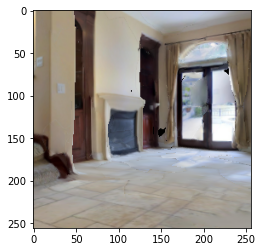

In [53]:
# observations = envs.reset()
# batch = batch_obs(observations, device)

observation = env.reset()

observations = [observation]
batch = batch_obs(observations, device)

imshow(observation["rgb"]);
print(observation["pointgoal_with_gps_compass"])

current_episodes = [env.current_episode]
print(current_episodes)

In [54]:
# current_episode_reward = torch.zeros(envs.num_envs, 1, device=device)

# test_recurrent_hidden_states = torch.zeros(
#     model.net.num_recurrent_layers,
#     config.NUM_PROCESSES,
#     args.hidden_size,
#     device=device,
# )
# prev_actions = torch.zeros(
#     config.NUM_PROCESSES, 1, device=device, dtype=torch.long
# )
# not_done_masks = torch.zeros(config.NUM_PROCESSES, 1, device=device)

# stats_episodes = dict()  # dict of dicts that stores stats per episode

# stats_actions = defaultdict(int)

# rgb_frames = [
#     [] for _ in range(config.NUM_PROCESSES)
# ]  # type: List[List[np.ndarray]]
# if len(config.VIDEO_OPTION) > 0:
#     os.makedirs(config.VIDEO_DIR, exist_ok=True)

num_envs = 1
num_processes = 1

current_episode_reward = torch.zeros(num_envs, 1, device=device)

test_recurrent_hidden_states = torch.zeros(
    model.net.num_recurrent_layers,
    num_processes,
    args.hidden_size,
    device=device,
)
prev_actions = torch.zeros(
    num_processes, 1, device=device, dtype=torch.long
)
not_done_masks = torch.zeros(num_processes, 1, device=device)

stats_episodes = dict()  # dict of dicts that stores stats per episode

stats_actions = defaultdict(int)

rgb_frames = [
    [] for _ in range(num_processes)
]  # type: List[List[np.ndarray]]
if len(config.VIDEO_OPTION) > 0:
    os.makedirs(config.VIDEO_DIR, exist_ok=True)

In [55]:
#
# start of main while loop
#

# current_episodes = envs.current_episodes()

current_episodes = [env.current_episode]
print(current_episodes)

[NavigationEpisode(episode_id='34606', scene_id='data/scene_datasets/gibson/Roeville.glb', start_position=[-6.106126308441162, -3.206904888153076, -2.0843334197998047], start_rotation=[0, 0.8751428732788948, 0, 0.48386460022320316], info={'geodesic_distance': 5.6181640625, 'difficulty': 'easy'}, _shortest_path_cache=<habitat_sim._ext.habitat_sim_bindings.MultiGoalShortestPath object at 0x7fb20d834d30>, goals=[NavigationGoal(position=[-1.8806381225585938, -3.206904888153076, -1.4072191715240479], radius=None)], start_room=None, shortest_paths=None)]


In [56]:
with torch.no_grad():
    _, actions, _, test_recurrent_hidden_states = model.act(
        batch,
        test_recurrent_hidden_states,
        prev_actions,
        not_done_masks,
        deterministic=False,
    )

    prev_actions.copy_(actions)

In [57]:
print(actions)
print(actions[0])
print(actions[0].item())

tensor([[3]])
tensor([3])
3


In [58]:
for a in actions:
    stats_actions[a[0].item()] += 1

print(stats_actions)

defaultdict(<class 'int'>, {3: 1})


In [61]:
env.habitat_env.task.get_action_name(a[0].item())

'TURN_RIGHT'

In [72]:
# outputs = env.step([a[0].item() for a in actions])
observation, reward, done, info = env.step(action=actions[0].item())

print(observation)
print(reward)
print(done)
print(info)

{'rgb': array([[[188, 160, 120],
        [188, 160, 120],
        [188, 160, 120],
        ...,
        [166, 139, 109],
        [166, 139, 109],
        [166, 139, 109]],

       [[188, 160, 120],
        [188, 160, 120],
        [188, 160, 120],
        ...,
        [166, 139, 109],
        [166, 139, 109],
        [166, 139, 109]],

       [[188, 160, 121],
        [188, 160, 121],
        [188, 160, 121],
        ...,
        [166, 139, 109],
        [166, 139, 109],
        [166, 139, 109]],

       ...,

       [[161, 133, 104],
        [160, 133, 104],
        [160, 132, 103],
        ...,
        [170, 141, 107],
        [173, 144, 110],
        [175, 146, 112]],

       [[164, 135, 104],
        [164, 135, 104],
        [164, 134, 104],
        ...,
        [172, 143, 109],
        [171, 142, 108],
        [172, 144, 110]],

       [[166, 136, 104],
        [167, 136, 104],
        [167, 136, 104],
        ...,
        [176, 146, 112],
        [175, 146, 112],
        [175, 14

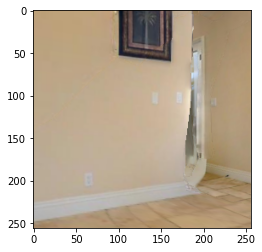

In [73]:
imshow(observation["rgb"]);

In [76]:
# observations, rewards, dones, infos = [list(x) for x in zip(*outputs)]
# batch = batch_obs(observations, device)

# observations, rewards, dones, infos = [observation], [reward], [done], [info]
# batch = batch_obs(observations, device)

# batch